In [11]:
import gym
import numpy as np
import matplotlib.pyplot as plt

In [12]:
def get_grid(grid_size=10):
    grid = []
    for i in [1,1,1,1,12.57,28.27]:
        grid.append(np.linspace(-i, i, grid_size))
    return np.array(grid)

def digitize_state(grid, state):
    return tuple([np.digitize(state[i], grid[i])-1 for i in range(len(state))])

In [13]:
def get_epsilon_greedy_action(q_values, epsilon, action_n):
    policy = np.ones(action_n) * epsilon / action_n
    max_action = np.argmax(q_values)
    policy[max_action] += 1 - epsilon
    return np.random.choice(np.arange(action_n), p=policy)


def MonteCarlo(state_n, action_n, env, episode_n, trajectory_len=500, gamma=0.99, grid_size=10):
    total_rewards = []
    grid = get_grid(grid_size=grid_size)
    qfunction = np.zeros([grid_size] * state_n + [action_n])
    counter = np.zeros([grid_size] * state_n + [action_n])

    for episode in range(episode_n):
        epsilon = 1 - episode / episode_n
        trajectory = {'states': [], 'actions': [], 'rewards': []}

        state = env.reset()
        state = digitize_state(grid, state)
        for _ in range(trajectory_len):
            trajectory['states'].append(state)

            action = get_epsilon_greedy_action(qfunction[state], epsilon, action_n)
            trajectory['actions'].append(action)

            state, reward, done, _ = env.step(action)
            state = digitize_state(grid, state)
            trajectory['rewards'].append(reward)

            if done:
                break

        total_rewards.append(sum(trajectory['rewards']))

        real_trajectory_len = len(trajectory['rewards'])
        returns = np.zeros(real_trajectory_len + 1)
        for t in range(real_trajectory_len - 1, -1, -1):
            returns[t] = trajectory['rewards'][t] + gamma * returns[t + 1]

        for t in range(real_trajectory_len):
            state = trajectory['states'][t]
            action = trajectory['actions'][t]
            qfunction[state][action] += (returns[t] - qfunction[state][action]) / (1 + counter[state][action])
            counter[state][action] += 1

    return total_rewards


In [14]:
def SARSA(state_n, action_n, env, episode_n, gamma=0.99, trajectory_len=500, alpha=0.5, grid_size=10):
    total_rewards = np.zeros(episode_n)
    grid = get_grid(grid_size=grid_size)
    qfunction = np.zeros([grid_size] * state_n + [action_n])

    for episode in range(episode_n):
        epsilon = 1 / (episode + 1)

        state = env.reset()
        state = digitize_state(grid, state)
        action = get_epsilon_greedy_action(qfunction[state], epsilon, action_n)
        for _ in range(trajectory_len):
            next_state, reward, done, _ = env.step(action)
            next_state = digitize_state(grid, next_state)
            next_action = get_epsilon_greedy_action(qfunction[next_state], epsilon, action_n)

            qfunction[state][action] += alpha * (reward + gamma * qfunction[next_state][next_action] - qfunction[state][action])

            state = next_state
            action = next_action

            total_rewards[episode] += reward

            if done:
                break

    return total_rewards

In [15]:
def QLearning(state_n, action_n, env, episode_n, gamma=0.99, trajectory_len=500, alpha=0.5, grid_size=10):
    total_rewards = np.zeros(episode_n)
    grid = get_grid(grid_size=grid_size)
    qfunction = np.zeros([grid_size] * state_n + [action_n])

    for episode in range(episode_n):
        epsilon = 1 / (episode + 1)

        state = env.reset()
        state = digitize_state(grid, state)
        action = get_epsilon_greedy_action(qfunction[state], epsilon, action_n)
        for _ in range(trajectory_len):
            next_state, reward, done, _ = env.step(action)
            next_state = digitize_state(grid, next_state)
            next_action = get_epsilon_greedy_action(qfunction[next_state], epsilon, action_n)

            max_q = max(qfunction[next_state])
            qfunction[state][action] += alpha * (reward + gamma * max_q - qfunction[state][action])

            state = next_state
            action = next_action

            total_rewards[episode] += reward

            if done:
                break

    return total_rewards


In [16]:
env = gym.make("Acrobot-v1")
STATE_N = 6
ACTION_N = 3


result = {}
result['qlearn'] = QLearning(STATE_N, ACTION_N, env, episode_n=200, trajectory_len=1000, gamma=0.999, alpha=0.5, grid_size=10)
result['sarsa'] = SARSA(STATE_N, ACTION_N, env, episode_n=200, trajectory_len=1000, gamma=0.999, alpha=0.5, grid_size=10)
result['monte_carlo'] = MonteCarlo(STATE_N, ACTION_N, env, episode_n=200, trajectory_len=1000, gamma=0.999, grid_size=10)
result.keys()

dict_keys(['qlearn', 'sarsa', 'monte_carlo'])

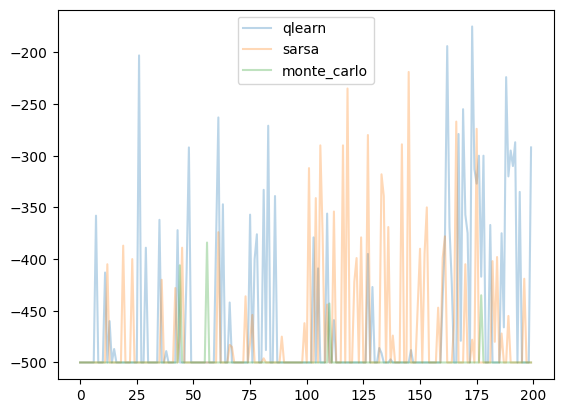

In [17]:
for key in result:
    plt.plot(result[key], label=key, alpha=0.3)
plt.legend()
plt.show()